## Imports

In [1]:
# General imports 
import pandas as pd
import numpy as np
import os
import re
import plotly.express as px
from tqdm import tqdm
import tempfile
import csv
import requests as r
from Bio import SeqIO
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import scipy


# Import structuremap functions
import structuremap.utils
structuremap.utils.set_logger()
from structuremap.processing import download_alphafold_cif, download_alphafold_pae, format_alphafold_data, annotate_accessibility, get_smooth_score, annotate_proteins_with_idr_pattern, get_extended_flexible_pattern, get_proximity_pvals, perform_enrichment_analysis, perform_enrichment_analysis_per_protein, evaluate_ptm_colocalization, extract_motifs_in_proteome
from structuremap.plotting import plot_enrichment, plot_ptm_colocalization

## Set Parameters of Analysis

In [2]:
analysis_threshold = 20 # number of amino acids either side to analyze

modifications = ["649.3660", "655.3735"] # which modifications we are looking for, as regex strings
heavy_modification = "655.3735" 
light_modification = "649.3660"

## Load Full Dataset (from ritwik-datagen-angel_annika.ipynb)

In [3]:
# path for csv output data
datasets_path_str = "../datasets/"
datasets_path = os.path.abspath(datasets_path_str)
print(datasets_path)

/Users/ritwiksrinivas/Desktop/Projects/methionine-analysis/datasets


In [4]:
path = os.path.join(datasets_path, "RvsS_peptides_with_alphafold.csv")
peptides_with_alphafold = pd.read_csv(path)
peptides_with_alphafold.set_index("Unnamed: 0", inplace=True)
peptides_with_alphafold.index.name = None
peptides_with_alphafold

,Peptide Sequence,Modified Peptide,Light Modified Peptide,Heavy Modified Peptide,1 Log2 Ratio HL,10 Log2 Ratio HL,11 Log2 Ratio HL,12 Log2 Ratio HL,2 Log2 Ratio HL,3 Log2 Ratio HL,...,nAA_24_180_pae,nAA_12_70_pae,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,IDR
0,AADTIGYPVMIR,AADTIGYPVMIR,AADTIGYPVM[649.3660]IR,AADTIGYPVM[655.3735]IR,NaN,NaN,3.269016,NaN,NaN,NaN,...,144,5,3,31,85,2.380952,22.190476,59.952381,120.857143,0
1,IAMQTLDMGR,IAMQTLDMGR,IAM[649.3660]QTLDMGR,IAM[655.3735]QTLDMGR,NaN,2.783695,3.114945,2.697822,NaN,NaN,...,173,1,2,19,90,2.761905,30.571429,90.857143,176.571429,0
2,FVGAVDPIMEK,FVGAVDPIMEK,FVGAVDPIM[649.3660]EK,FVGAVDPIM[655.3735]EK,NaN,NaN,NaN,NaN,NaN,2.383482,...,52,2,3,9,24,2.238095,11.238095,29.571429,61.952381,0
3,QAQYLGMPINGPFKPDHYRY,QAQYLGMPINGPFKPDHYRY,QAQYLGM[649.3660]PINGPFKPDHYRY,QAQYLGM[655.3735]PINGPFKPDHYRY,2.394458,2.380664,2.682897,NaN,2.435014,2.412394,...,39,5,2,15,24,2.095238,13.380952,27.047619,48.190476,0
4,FADVIPMNLPHR,FADVIPMNLPHR,FADVIPM[649.3660]NLPHR,FADVIPM[655.3735]NLPHR,NaN,NaN,2.580647,NaN,2.446614,2.450718,...,207,6,3,27,104,2.857143,27.523810,85.285714,171.619048,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,AHMVTLDYTVQVPGTGR,AHMVTLDYTVQVPGTGR,AHM[649.3660]VTLDYTVQVPGTGR,AHM[655.3735]VTLDYTVQVPGTGR,-1.822067,-1.687501,-1.706146,-1.647231,-1.793966,-1.407199,...,104,2,3,25,60,2.523810,16.476190,42.238095,79.904762,0
199,KEQESEVDMK,KEQESEVDMK,KEQESEVDM[649.3660]K,KEQESEVDM[655.3735]K,-1.759694,NaN,-1.821773,-1.960428,-1.781592,-1.988603,...,19,0,2,7,11,2.000000,7.190476,12.523810,19.428571,1
200,RGVMLAVDAVIAELK,RGVMLAVDAVIAELK,RGVM[649.3660]LAVDAVIAELK,RGVM[655.3735]LAVDAVIAELK,-1.812349,-1.980371,-2.307386,-2.492858,-1.405837,-2.094407,...,128,2,3,26,71,2.857143,26.095238,62.571429,115.380952,0
201,MQLLEIITTDK,MQLLEIITTDK,M[649.3660]QLLEIITTDK,M[655.3735]QLLEIITTDK,-2.286954,-2.700322,-1.941018,-1.860306,-2.069488,NaN,...,158,8,2,15,55,2.571429,25.952381,80.380952,173.428571,0


# Analysis Playground

<Axes: xlabel='nAA_12_180_pae', ylabel='Density'>

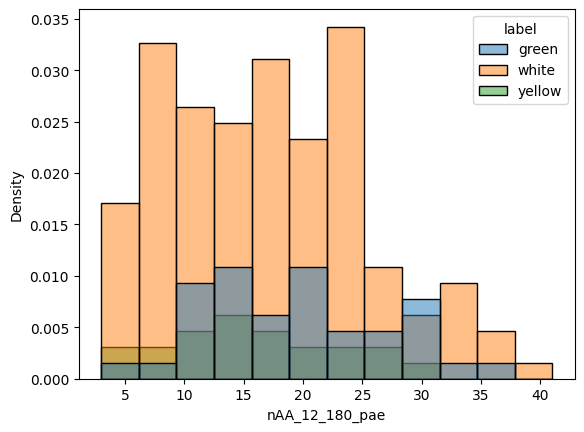

In [5]:
cols_to_visualize = ["nAA_6_180_pae", "nAA_12_180_pae", "nAA_18_180_pae", "nAA_24_180_pae", "nAA_24_180_pae_smooth10", "nAA_6_180_pae_smooth10", "nAA_12_180_pae_smooth10", "nAA_18_180_pae_smooth10", "IDR"]

sns.histplot(data=peptides_with_alphafold, x=cols_to_visualize[1], hue="label", stat="density")

In [6]:
peptides_with_alphafold.groupby("label")[cols_to_visualize].agg(np.mean)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_9176/1280371745.py:1: FutureWarning: The provided callable <function mean at 0x11287d550> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  peptides_with_alphafold.groupby("label")[cols_to_visualize].agg(np.mean)


,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_24_180_pae,nAA_24_180_pae_smooth10,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,IDR
label,,,,,,,,,
green,2.461538,19.461538,55.769231,103.846154,97.417582,2.403541,18.932234,51.292430,0.025641
white,2.349650,17.013986,45.608392,87.832168,84.187780,2.283280,16.479866,44.194430,0.181818
yellow,2.238095,16.142857,43.238095,79.761905,79.859410,2.350718,17.051398,43.321618,0.190476


In [7]:
peptides_with_alphafold.groupby("label")[cols_to_visualize].agg(np.median)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_9176/4091559531.py:1: FutureWarning: The provided callable <function median at 0x1129b3f70> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  peptides_with_alphafold.groupby("label")[cols_to_visualize].agg(np.median)


,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_24_180_pae,nAA_24_180_pae_smooth10,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,IDR
label,,,,,,,,,
green,2.0,19.0,53.0,104.0,96.238095,2.285714,18.523810,50.142857,0.0
white,2.0,16.0,47.0,85.0,92.380952,2.238095,16.571429,47.714286,0.0
yellow,2.0,15.0,46.0,80.0,76.952381,2.285714,16.095238,40.238095,0.0


In [8]:
peptides_with_alphafold["structure_group"]

0              STRN
1              HELX
2              HELX
3              BEND
4              TURN
           ...     
198            STRN
199            HELX
200            HELX
201    unstructured
202            HELX
Name: structure_group, Length: 203, dtype: object

In [9]:
peptides_with_alphafold.groupby(["label", "structure_group"]).agg("count").rename({"Peptide Sequence": "Count"}, axis=1)[["Count"]]

Count
label  structure_group       
green  BEND                 5
       HELX                23
       STRN                 7
       TURN                 3
       unstructured         1
white  BEND                12
       HELX                87
       STRN                16
       TURN                11
       unstructured        17
yellow BEND                 3
       HELX                11
       STRN                 3
       TURN                 3
       unstructured         1

In [10]:
# analysis for radius = 18

# Filter the dataset for what we want to compare:
green = peptides_with_alphafold[peptides_with_alphafold['label'] == 'green']
white = peptides_with_alphafold[peptides_with_alphafold['label'] == 'white']

green = green['nAA_18_180_pae']
white = white['nAA_18_180_pae']

# Perform the t-test:
#t_stat, p_value = scipy.stats.ttest_ind(green, white)
scipy.stats.ttest_ind(green, white)

TtestResult(statistic=2.2546986381141707, pvalue=0.02535716483878465, df=180.0)

In [11]:
# analysis for radius = 18

# Filter the dataset for what we want to compare:
green = peptides_with_alphafold[peptides_with_alphafold['label'] == 'green']
yellow = peptides_with_alphafold[peptides_with_alphafold['label'] == 'yellow']

green = green['nAA_18_180_pae']
yellow = yellow['nAA_18_180_pae']

# Perform the t-test:
#t_stat, p_value = scipy.stats.ttest_ind(green, white)
scipy.stats.ttest_ind(green, yellow)

TtestResult(statistic=1.7581088545452634, pvalue=0.08400483277415433, df=58.0)

In [12]:
temp_pwa = peptides_with_alphafold.copy()
temp_pwa["is_enriched"] = temp_pwa["label"].apply(lambda label: 1 if label == "yellow" or label == "green" else 0)

temp_pwa.groupby("is_enriched")[cols_to_visualize].agg(np.mean)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_9176/1697412143.py:4: FutureWarning: The provided callable <function mean at 0x11287d550> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  temp_pwa.groupby("is_enriched")[cols_to_visualize].agg(np.mean)


,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_24_180_pae,nAA_24_180_pae_smooth10,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,IDR
is_enriched,,,,,,,,,
0,2.349650,17.013986,45.608392,87.832168,84.187780,2.283280,16.479866,44.194430,0.181818
1,2.383333,18.300000,51.383333,95.416667,91.272222,2.385053,18.273942,48.502646,0.083333


In [13]:
# analysis for radius = 10

# Filter the dataset for what we want to compare:
enriched = temp_pwa[temp_pwa['is_enriched'] == 1]
not_enriched = temp_pwa[temp_pwa['is_enriched'] == 0]

enriched = enriched['nAA_24_180_pae']
not_enriched = not_enriched['nAA_24_180_pae']

# Perform the t-test:
#t_stat, p_value = scipy.stats.ttest_ind(green, white)
scipy.stats.ttest_ind(enriched, not_enriched)

TtestResult(statistic=0.9356959441641113, pvalue=0.35055257358445235, df=201.0)

<Axes: xlabel='nAA_12_180_pae', ylabel='Density'>

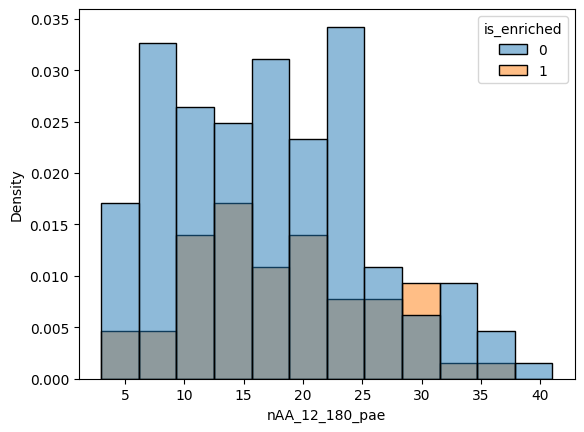

In [14]:
sns.histplot(data=temp_pwa, x=cols_to_visualize[1], hue="is_enriched", stat="density")

In [15]:
temp_pwa.groupby("is_enriched")[cols_to_visualize].agg(np.var)

/var/folders/75/pkq34r597jg472ny6_np6tdc0000gn/T/ipykernel_9176/3443811401.py:1: FutureWarning: The provided callable <function var at 0x11287d790> is currently using DataFrameGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  temp_pwa.groupby("is_enriched")[cols_to_visualize].agg(np.var)


,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_24_180_pae,nAA_24_180_pae_smooth10,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,IDR
is_enriched,,,,,,,,,
0,0.482517,68.239240,590.620211,2722.633606,1896.166145,0.068095,36.931846,409.107035,0.149808
1,0.342090,57.298305,718.037006,2907.840395,1797.610369,0.077325,38.487632,404.451404,0.077684


In [16]:
temp_pwa["Protein ID"]

0      Q8C196
1      Q07417
2      Q91YI0
3      P50247
4      P33267
        ...  
198    Q9QXF8
199    Q8K3J1
200    P63038
201    Q8BMS1
202    Q01853
Name: Protein ID, Length: 203, dtype: object

# Full Proteome Analysis ???

In [17]:
path = os.path.join(datasets_path, "RvsS_full_mitochondrial_with_alphafold.csv")
mitocarta3_0_methionines_with_alphafold = pd.read_csv(path)
mitocarta3_0_methionines_with_alphafold.set_index("Unnamed: 0", inplace=True)
mitocarta3_0_methionines_with_alphafold.index.name = None
mitocarta3_0_methionines_with_alphafold

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,nAA_6_180_pae,nAA_12_180_pae,nAA_18_180_pae,nAA_6_180_pae_smooth10,nAA_12_180_pae_smooth10,nAA_18_180_pae_smooth10,nAA_24_180_pae_smooth10,IDR,UniProt-Primary,Complete Sequence
0,A2ADF7,1,M,0,34.90,-16.170,-15.807,-16.898,-15.637,-29.957,...,1,2,3,1.909091,3.727273,5.545455,8.454545,1,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...
1,A2ADF7,1,M,7,25.00,-17.959,-18.801,-19.503,-17.880,-11.797,...,2,4,7,1.944444,4.000000,6.555556,10.500000,1,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...
2,A2ADF7,1,M,11,31.62,-22.014,-20.790,-20.768,-20.882,-2.522,...,2,4,7,2.000000,5.000000,9.142857,17.666667,1,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...
3,A2ADF7,1,M,16,60.19,-24.992,-24.872,-26.170,-24.382,3.164,...,2,4,9,2.142857,7.666667,17.238095,32.380952,1,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...
4,A2ADF7,1,M,96,86.39,-12.515,-11.617,-10.128,-11.907,1.475,...,2,23,54,2.428571,19.047619,51.666667,104.095238,0,A2ADF7,MKPTQAQMAPAMDSREMVSPAVDLVLGASACCLACVFTNPLEVVKT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4843,S4R2K0,528,M,90,98.40,-3.270,-3.856,-3.011,-5.229,-11.159,...,2,28,66,2.285714,25.428571,66.619048,119.285714,0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...
4844,S4R2K0,528,M,132,98.22,14.774,14.306,13.644,15.422,-7.821,...,3,23,51,2.428571,18.952381,49.142857,89.476190,0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...
4845,S4R2K0,528,M,203,98.79,0.508,1.302,2.674,1.468,3.585,...,2,32,98,2.333333,28.714286,82.714286,134.619048,0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...
4846,S4R2K0,528,M,215,98.03,3.940,3.358,2.382,2.708,12.422,...,3,20,46,2.333333,18.619048,46.714286,87.380952,0,S4R2K0,MLLLGRLPRPAWVPGSRAQRCSSLAALEGPARTRSYWRYLRRLVCG...


In [18]:
peptides_with_alphafold.columns

Index(['Peptide Sequence', 'Modified Peptide', 'Light Modified Peptide',
       'Heavy Modified Peptide', '1 Log2 Ratio HL', '10 Log2 Ratio HL',
       '11 Log2 Ratio HL', '12 Log2 Ratio HL', '2 Log2 Ratio HL',
       '3 Log2 Ratio HL', '4 Log2 Ratio HL', '5 Log2 Ratio HL',
       '6 Log2 Ratio HL', '7 Log2 Ratio HL', '8 Log2 Ratio HL',
       '9 Log2 Ratio HL', 'Protein', 'Protein ID', 'Entry Name', 'Gene',
       'Protein Description', 'p-value', 'neglogp', 'Log2HL avg', 'label',
       'Complete Sequence', 'Sequence Location', 'Sequence Length',
       'Left Prefix', 'Left Prefix Length', 'Methionine Location', 'Left 20',
       'Right 20', 'protein_id', 'protein_number', 'AA', 'position', 'quality',
       'x_coord_c', 'x_coord_ca', 'x_coord_cb', 'x_coord_n', 'y_coord_c',
       'y_coord_ca', 'y_coord_cb', 'y_coord_n', 'z_coord_c', 'z_coord_ca',
       'z_coord_cb', 'z_coord_n', 'secondary_structure', 'structure_group',
       'BEND', 'HELX', 'STRN', 'TURN', 'unstructured', 'nAA_24

In [19]:
mitocarta3_0_methionines_with_alphafold.columns

Index(['protein_id', 'protein_number', 'AA', 'position', 'quality',
       'x_coord_c', 'x_coord_ca', 'x_coord_cb', 'x_coord_n', 'y_coord_c',
       'y_coord_ca', 'y_coord_cb', 'y_coord_n', 'z_coord_c', 'z_coord_ca',
       'z_coord_cb', 'z_coord_n', 'secondary_structure', 'structure_group',
       'BEND', 'HELX', 'STRN', 'TURN', 'unstructured', 'nAA_24_180_pae',
       'nAA_12_70_pae', 'nAA_6_180_pae', 'nAA_12_180_pae', 'nAA_18_180_pae',
       'nAA_6_180_pae_smooth10', 'nAA_12_180_pae_smooth10',
       'nAA_18_180_pae_smooth10', 'nAA_24_180_pae_smooth10', 'IDR',
       'UniProt-Primary', 'Complete Sequence'],
      dtype='object')

In [ ]:
in_both = pd.merge(left=peptides_with_alphafold, right=mitocarta3_0_methionines_with_alphafold, left_on=[""])